<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preambles" data-toc-modified-id="Preambles-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preambles</a></span></li><li><span><a href="#Qubit-parameters" data-toc-modified-id="Qubit-parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Qubit parameters</a></span></li><li><span><a href="#Drive-parameters" data-toc-modified-id="Drive-parameters-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Drive parameters</a></span></li><li><span><a href="#Extract-rate" data-toc-modified-id="Extract-rate-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Extract rate</a></span></li></ul></div>

# Preambles

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from qutip import*
from scipy.special import eval_hermite as hpoly
import sys
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import qchard_coupobj as coupobj
from Fluxonium_hamiltonians import qchard_transmon as transmon
from Fluxonium_hamiltonians import qchard_pshapes as pshapes
from Fluxonium_hamiltonians import qchard_evolgates as gates
from Fluxonium_hamiltonians import qchard_evolgates_twod as gates_2d
from Fluxonium_hamiltonians import qchard_rotope as op
import plotting_settings
from scipy.optimize import curve_fit
import scipy.linalg
from scipy.optimize import minimize
from scipy.optimize import optimize

In [14]:
def line_func(x,slope,c1,c2):
    return slope*(x-c1)+c2

def cos_func(x,amp,freq,c1,c2):
    return amp*np.cos(2*np.pi*freq*(x-c1))+c2

# Qubit parameters

In [87]:
omega1 = 5.254 #GHz
omega2 = 5.331
omega3 = 5.491
alpha1 = -0.277
alpha2 = -0.272
alpha3 = -0.271
nlev = 3

qubit1 = transmon.TransmonSimple(omega_q = omega1, alpha = alpha1, nlev = nlev)
qubit2 = transmon.TransmonSimple(omega_q = omega2, alpha = alpha2, nlev = nlev)
qubit3 = transmon.TransmonSimple(omega_q = omega3, alpha = alpha3, nlev = nlev)
JC = 0.0025 #GHz
coupling_type = 'JC-rwa'
system = coupobj.CoupledObjects(qubit1, qubit2,
    [qubit1, qubit2, 0.0024, coupling_type])
vec00 = system.eigvec('00')
vec01 = system.eigvec('10')
vec10 = system.eigvec('10')
vec11 = system.eigvec('11')


# system = coupobj.CoupledObjects(qubit1, qubit2,qubit3,
#     [qubit1, qubit2, 0.0024, coupling_type],
#     [qubit2, qubit3, 0.003, coupling_type])
# vec000 = system.eigvec('000')
# vec001 = system.eigvec('010')
# vec010 = system.eigvec('010')
# vec011 = system.eigvec('011')
# vec100 = system.eigvec('100')
# vec101 = system.eigvec('101')
# vec110 = system.eigvec('110')
# vec111 = system.eigvec('111')


# Drive parameters

In [104]:
#Gate parameters
shape = 'cosflattop'
T_gate = 375 #ns
T_rise = 30
drag = False
drag_coeff = 0.0
sigma = 0.25
coupl = 10 #MHz
coupl_const = coupl*1e-3*2*np.pi
eta = 0.3

#Drive amplitude and frequency
omega_d1 = abs(system.freq('00', '01')) 
omega_d2 = abs(system.freq('00', '01')) 

#Evolve gate
t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)
H_drive1 = coupl_const * (system.a(0) + system.a(0).dag())
H_drive2 = eta * coupl_const * (system.a(1) + system.a(1).dag())
U_t = gates_2d.evolution_operator_microwave_nonorm(
                system.H(), H_drive1, H_drive2, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, T_rise = T_rise, shape=shape, sigma=sigma, omega_d1=omega_d1,omega_d2=omega_d2)

# Extract rate

Text(0, 0.5, '$P_{00}$')

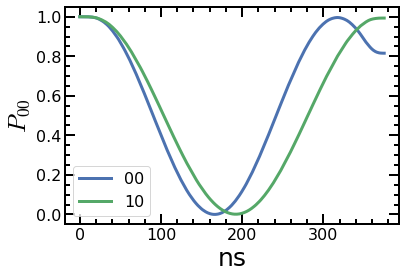

In [105]:
plt.plot(t_points, expect(vec00*vec00.dag(), U_t*vec00), label = '00')
plt.plot(t_points, expect(vec10*vec10.dag(), U_t*vec10), label = '10')
plt.legend()
plt.xlabel("ns")
plt.ylabel(r'$P_{00}$')

0.02255750195170441
12.17916118413087


Text(0, 0.5, '$\\phi_{00}+\\phi_{11}-\\phi_{10}-\\phi_{01}$')

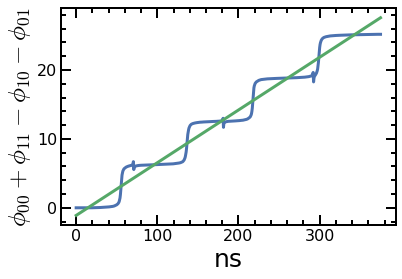

In [81]:
phase_evol = np.zeros_like(t_points)
for tind in range(len(t_points)):
    u00 = U_t[tind].matrix_element(vec00.dag(), vec00)
    u01 = U_t[tind].matrix_element(vec01.dag(), vec01)
    u10 = U_t[tind].matrix_element(vec10.dag(), vec10)
    u11 = U_t[tind].matrix_element(vec11.dag(), vec11)
    phase_evol[tind] = np.angle(u11 * u00 / (u10 * u01))

plt.plot(t_points, np.unwrap(phase_evol))
slope_guess = (phase_evol[-1]-phase_evol[0])/(t_points[-1]-t_points[0])
print (slope_guess/(2*np.pi)*1e3)
guess = [slope_guess,0,0]
opt, cov = curve_fit(line_func,xdata = t_points, ydata=np.unwrap(phase_evol), p0=guess)
zeta_ZZ = opt[0]/(2*np.pi)*1e3
print (zeta_ZZ)
plt.plot(t_points, line_func(t_points,*opt))
plt.xlabel("ns")
plt.ylabel(r'$\phi_{00}+\phi_{11}-\phi_{10}-\phi_{01}$')